# Imports

In [1]:
import pandas as pd
import geopandas as gpd

import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib.pyplot as plt

import mapclassify as mc

from helper_scripts import utils

# Load data

In [2]:
# Load districtwise map data
map_data = gpd.read_file('../data/nepal_map_data/nepal-districts.geojson')

# Load number of enrollments and teachers data
raw_enrollments_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-primary-school-districtwise.csv')
raw_enrollments_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-lower-secondary-districtwise.csv')
raw_enrollments_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-secondary-districtwise.csv')

raw_teachers_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/primary-teachers-districtwise.csv')
raw_teachers_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/lower-secondary-teachers-districtwise.csv')
raw_teachers_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/secondary-school-teachers-districtwise.csv')

# Preprocess

In [3]:
# rename columns and remove unnecessary aggregate row
# we only need the year and district data
year = '2015'

enrollments_primary = raw_enrollments_primary.rename(columns={'District':'DISTRICT', year:'Enrollments'})[:-1]
enrollments_primary = enrollments_primary[['DISTRICT','Enrollments']]

teachers_primary = raw_teachers_primary.rename(columns={'Region/District':'DISTRICT', year:'Teachers'})[:-1]
teachers_primary = teachers_primary[['DISTRICT','Teachers']]

# calculate the composite measure in a new frame, and add it to the geo data
prelem_ratio_dataframe = pd.merge(enrollments_primary, teachers_primary, how='inner', on='DISTRICT')
prelem_ratio_dataframe['ratio'] = round(prelem_ratio_dataframe['Enrollments']/prelem_ratio_dataframe['Teachers'], 2)

# match the cases and merge with the map data
prelem_ratio_dataframe['DISTRICT'] = prelem_ratio_dataframe['DISTRICT'].str.upper()

final_ratio_data = map_data.merge(prelem_ratio_dataframe, how='inner', on='DISTRICT')

# PLOT IN A MAP!

POLYGON ((81.40184783935547 30.359201431274414, 81.40120697021484 30.360641479492188, 81.4002456665039 30.362661361694336, 81.39794921875 30.363842010498047, 81.39568328857422 30.3673095703125, 81.39769744873047 30.369009017944336, 81.40133666992188 30.369264602661133, 81.40563201904297 30.368925094604492, 81.4099349975586 30.369173049926758, 81.41324615478516 30.369422912597656, 81.41720581054688 30.368810653686523, 81.42052459716797 30.36963653564453, 81.42353820800781 30.372188568115234, 81.424560546875 30.3739070892334, 81.42459869384766 30.376779556274414, 81.42494201660156 30.37763214111328, 81.4266128540039 30.378767013549805, 81.42864227294922 30.381616592407227, 81.4280014038086 30.383066177368164, 81.42469787597656 30.38309669494629, 81.42174530029297 30.384563446044922, 81.4194564819336 30.386598587036133, 81.41619110107422 30.389503479003906, 81.41224670410156 30.390981674194336, 81.40863037109375 30.392744064331055, 81.4036865234375 30.393945693969727, 81.4007339477539 30.

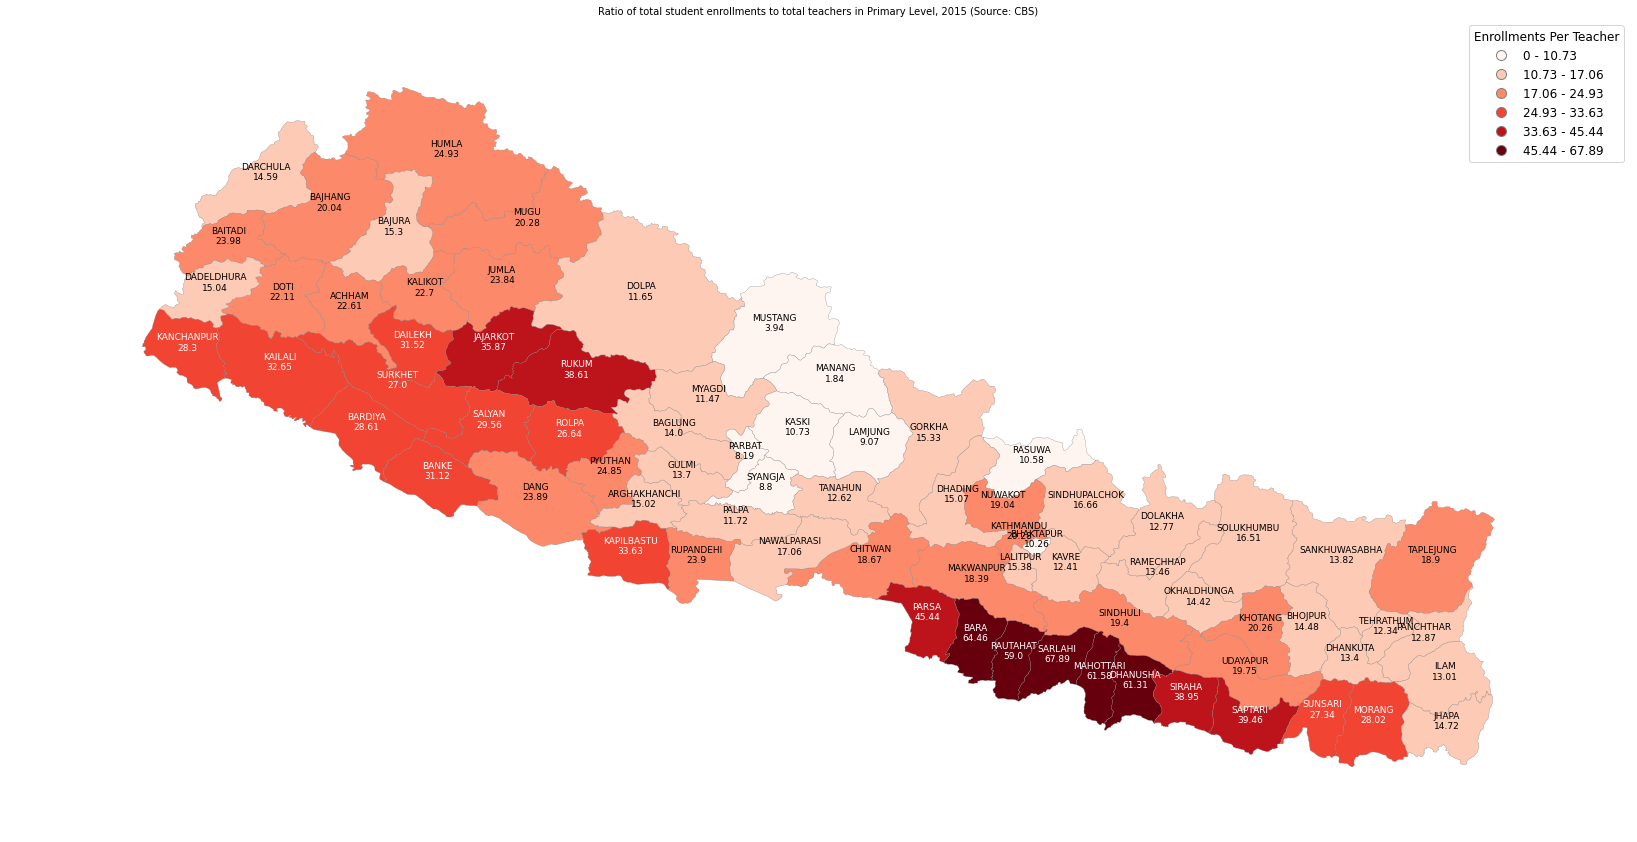

In [4]:
scheme = mc.FisherJenks(final_ratio_data['ratio'], k=6)

ax = gplt.choropleth(
    final_ratio_data, figsize=(30,15),
    hue='ratio', 
    cmap='Reds', linewidth=0.3, edgecolor='gray',
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Enrollments Per Teacher",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

# apply labels to every district so they appear on map
final_ratio_data.apply(utils.annotate_polygons(ax, annotation_field='DISTRICT',annotation_value_field='ratio', threshold=24.94), axis=1)

plt.title("Ratio of total student enrollments to total teachers in Primary Level, 2015 (Source: CBS)", fontdict={"fontsize": 10}, pad=5)
plt.savefig('../visualizations/PrimaryStudentTeacher.svg', bbox_inches='tight')